In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab06.ipynb")

# Lab 6: Linear Regression



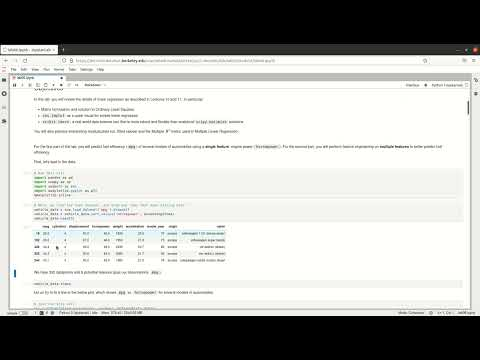

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("IkkhAr3e19Q", list = 'PLQCcNQgUcDfpuwnASdUyvQky51ZcYMWSy', listType = 'playlist')

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Objectives

In this lab, you will review the details of linear regresison as described in Lectures 10 and 11. In particular:

* Matrix formulation and solution to Ordinary Least Squares
* `sns.lmplot` as a quick visual for simple linear regression
* `scikit-learn`, a real world data science tool that is more robust and flexible than analytical/`scipy.optimize` solutions

You will also practice interpreting residual plots (vs. fitted values) and the Multiple $R^2$ metric used in Multiple Linear Regression.

<br/>

For the first part of this lab, you will predict fuel efficiency (`mpg`) of several models of automobiles using a **single feature**: engine power (`horsepower`). For the second part, you will perform feature engineering on **multiple features** to better predict fuel efficiency.

First, let's load in the data.

In [3]:
# Run this cell
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Here, we load the fuel dataset, and drop any rows that have missing data
vehicle_data = sns.load_dataset('mpg').dropna()
vehicle_data = vehicle_data.sort_values('horsepower', ascending=True)
vehicle_data.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


We have 392 datapoints and 8 potential features (plus our observations, `mpg`).

In [5]:
vehicle_data.shape

(392, 9)

Let us try to fit a line to the below plot, which shows `mpg` vs. `horsepower` for several models of automobiles.

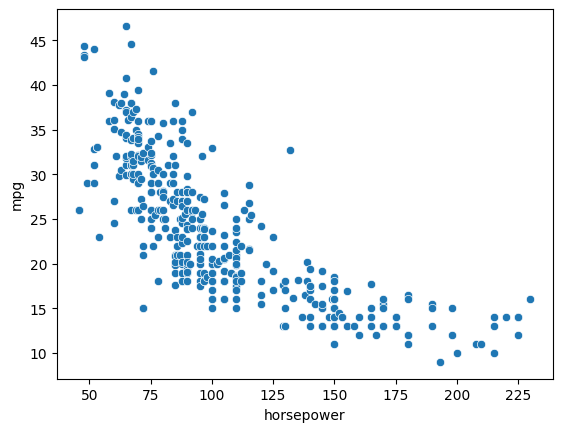

In [6]:
# just run this cell
sns.scatterplot(x='horsepower', y='mpg', data=vehicle_data);

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1: Ordinary Least Squares

Instead of using the SLR formulation, in this lab we will practice linear algebra with Ordinary Least Squares. Recall that the Simple Linear Regression model is written as follows:

$$\hat{y} = \theta_0 + \theta_1 x$$

We now use $\theta = (\theta_0, \theta_1)$ so that the formulation more closely matches our multiple linear regression model:

$$\hat{y} = \theta_0 + \theta_1 x_1 + \dots + \theta_p x_p$$

We can rewrite our multiple linear regression model using matrix notation. Let $\mathbb{Y}$ be a vector of all $n$ observations in our sample. Then our prediction vector $\hat{\mathbb{Y}}$ is

$$\Large \hat{\mathbb{Y}} = \mathbb{X} \theta$$

where $\mathbb{X}$ is the **design matrix** representing the $p$ features for all $n$ datapoints in our sample.

Note that for our SLR model, $p = 1$ and therefore the matrix notation seems rather silly. Nevertheless it is valuable to start small and build on our intuition.

---

### Question 1a: Construct $\mathbb{X}$ with an intercept term

Because we have an intercept term $\theta_0$ in our parameter vector $\theta$, our design matrix $\mathbb{X}$ for $p$ features actually has dimension

$$ \Large \mathbb{X} \in \mathbb{R}^{n \times (p + 1)}$$

Therefore, the resulting matrix expression $\hat{\mathbb{Y}} = \mathbb{X} \theta$ represents $n$ linear equations, where equation $i$ is $\hat{y_i} = \theta_0 \cdot 1 + \theta_1 \cdot x_1 + \dots + \theta_p x_p$. The constant all-ones column of $\mathbb{X}$ is sometimes called the bias feature; $\theta_0$ is frequently called the **bias or intercept term**.

<br/>

Below, implement `add_intercept`, which computes a design matrix such that the first (left-most) column is all ones. The function has two lines: you are responsible for constructing the all-ones column `bias_feature` using the `np.ones` function (NumPy [documentation](https://numpy.org/doc/stable/reference/generated/numpy.ones.html?highlight=ones)). This is then piped into a call to `np.concatenate` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)), which we've implemented for you.

Note: `bias_feature` should be a matrix of dimension `(n,1)`, not a vector of dimension `(n,)`.

<!--
BEGIN QUESTION
name: q1a
-->

In [7]:
def add_intercept(X):
    """
    Return X with a bias feature.
    
    Parameters
    -----------
    X: a 2D dataframe of p numeric features
    (may also be a 2D numpy array) of shape n x p
    
    Returns
    -----------
    A 2D matrix of shape n x (p + 1), where the leftmost
    column is a column vector of 1's
    """
    bias_feature = np.ones((X.shape[0], 1))
    return np.concatenate([bias_feature, X], axis=1) # 矩阵拼接

# Note the [[ ]] brackets below: the argument needs to be
# a matrix (DataFrame), as opposed to a single array (Series).
X = add_intercept(vehicle_data[['horsepower']])
X.shape

(392, 2)

In [ ]:
grader.check("q1a")

---
### Question 1b: Define the OLS Model

The predictions for all $n$ points in our data are (note $\theta = (\theta_0, \theta_1, \dots, \theta_p)$) :
$$ \Large \hat{\mathbb{Y}} = \mathbb{X}\theta $$

Below, implement the `linear_model` function to evaluate this product.

**Hint**: You can use [np.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [pd.DataFrame.dot](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dot.html), or the `@` operator to multiply matrices/vectors. However, while the `@` operator can be used to multiply `numpy` arrays, it generally will not work between two `pandas` objects, so keep that in mind when computing matrix-vector products!


<!--
BEGIN QUESTION
name: q1b
-->

In [9]:
def linear_model(thetas, X):
    """
    Return the linear combination of thetas and features as defined above.
    
    Parameters
    -----------
    thetas: a 1D vector representing the parameters of our model ([theta1, theta2, ...])
    X: a 2D dataframe of numeric features (may also be a 2D numpy array)
    
    Returns
    -----------
    A 1D vector representing the linear combination of thetas and features as defined above.
    """
    return np.dot(X, thetas)

In [ ]:
grader.check("q1b")

---

### Question 1c: Least Squares Estimate, Analytically, 常见的矩阵操作

Recall from lecture that Ordinary Least Squares is when we fit a linear model with mean squared error, which is equivalent to the following optimization problem:

$$\Large \min_{\theta} ||\Bbb{X}\theta - \Bbb{Y}||^2$$

We showed in Lecture that the optimal estimate $\hat{\theta}$ when $X^TX$ is invertible is given by the equation:

$$ \Large \hat{\theta} = (\Bbb{X}^T\Bbb{X})^{-1}\Bbb{X}^T\Bbb{Y}$$

Below, implement the analytic solution to $\hat{\theta}$ using `np.linalg.inv` ([link](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)) to compute the inverse of $\Bbb{X}^T\Bbb{X}$.

Reminder: To compute the transpose of a matrix, you can use `X.T` or `X.transpose()` ([link](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T)).

Note: You can also consider using `np.linalg.solve` ([link](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html)) instead of `np.linalg.inv` because it is more robust (more on StackOverflow [here](https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li)). 

<!--
BEGIN QUESTION
name: q1c
-->

In [11]:
def get_analytical_sol(X, y):
    """
    Computes the analytical solution to our
    least squares problem
    
    Parameters
    -----------
    X: a 2D dataframe (or numpy array) of numeric features
    y: a 1D vector of tip amounts
    
    Returns
    -----------
    The estimate for theta (a 1D vector) computed using the
    equation mentioned above.
    """
    return np.linalg.inv(X.T @ X) @ X.T @ y

Y = vehicle_data['mpg']
analytical_thetas = get_analytical_sol(X, Y)
analytical_thetas

array([39.93586102, -0.15784473])

In [ ]:
grader.check("q1c")

<br/><br/>

Now, let's analyze our model's performance. Your task will be to interpret the model's performance using the two visualizations and one performance metric we've implemented below.

First, we run **`sns.lmplot`**, which will both provide a scatterplot of `mpg` vs `horsepower` and display the least-squares line of best fit. (If you'd like to verify the OLS fit you found above is the same line found through Seaborn, change `include_OLS` to `True`.)

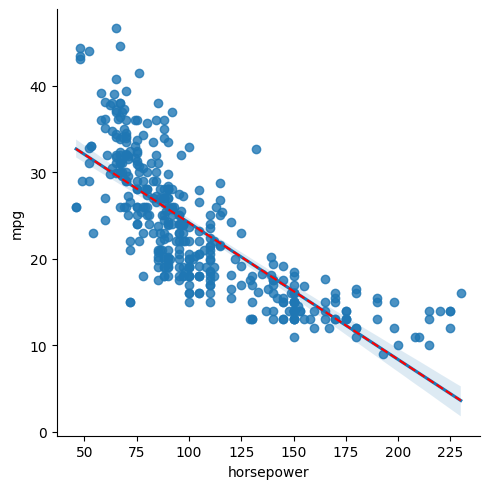

In [14]:
include_OLS = True # change this flag to visualize OLS fit

sns.lmplot(x='horsepower', y='mpg', data=vehicle_data);
predicted_mpg_hp_only = linear_model(analytical_thetas, X)
if include_OLS:
    # if flag is on, add OLS fit as a dotted red line
    plt.plot(vehicle_data['horsepower'], predicted_mpg_hp_only, 'r--')

Next, we **plot the residuals.** While in Simple Linear Regression we have the option to plot residuals vs. the single input feature, in Multiple Linear Regression we often plot residuals vs fitted values $\hat{\mathbb{Y}}$. In this lab, we opt for the latter.

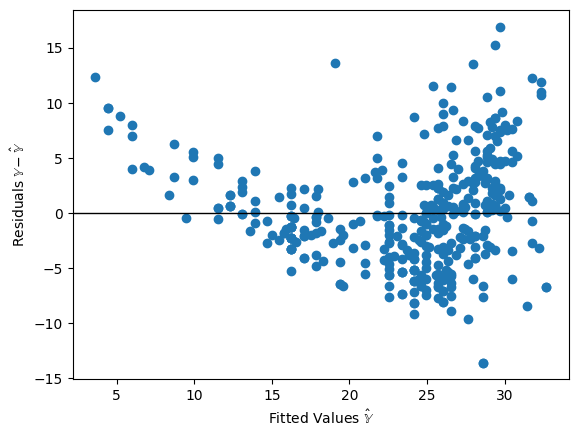

In [15]:
plt.scatter(predicted_mpg_hp_only, Y - predicted_mpg_hp_only)
plt.axhline(0, c='black', linewidth=1)
plt.xlabel(r'Fitted Values $\hat{\mathbb{Y}}$')
plt.ylabel(r'Residuals $\mathbb{Y} - \hat{\mathbb{Y}}$');

Finally, we compute the **Multiple $R^2$** metric. As described in Lecture 11 ([link](https://docs.google.com/presentation/d/15eEbroVt2r36TXh28C2wm6wgUHlCBCsODR09kLHhDJ8/edit#slide=id.g1163459c7f0_0_86)),

$$R^2 = \frac{\text{variance of fitted values}}{\text{variance of true } y} = \frac{\sigma_{\hat{y}}^2}{\sigma_y^2}$$

$R^2$  can be used
in the multiple regression setting, whereas $r$ (the correlation coefficient) is restricted to SLR since it depends on a single input feature.  In SLR, $r^{2}$ and Multiple $R^{2}$ are
equivalent; the proof is left to you.

In [16]:
r2_hp_only = np.var(predicted_mpg_hp_only) / np.var(Y)

print('Multiple R^2 using only horsepower: ', r2_hp_only)

Multiple R^2 using only horsepower:  0.6059482578894348


---
### Question 1d

In the cell below, comment on the above visualization and performance metrics, and whether `horsepower` and `mpg` have a good linear fit.

<!--
BEGIN QUESTION
name: q1d
-->

_poor performance_

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 2: Transform a Single Feature

The Tukey-Mosteller Bulge Diagram tells us to transform our $\mathbb{X}$ or $\mathbb{Y}$ to find a linear fit.

Let's consider the following linear model:

$$\text{predicted mpg} = \theta_0 + \theta_1 \sqrt{\text{horsepower}}$$

---
### Question 2a

In the cell below, explain why we use the term "linear" to describe the model above, even though it incorporates a square-root of horsepower  as a feature.

<!--
BEGIN QUESTION
name: q2a
-->

_泛化线性模型_

### Introduction to `sklearn`

Yet another way to fit a linear regression model is to use **scikit learn**, an industry standard package for machine learning applications. Because it is application-specific, `sklearn` is often faster and more robust than the analytical/`scipy`-based computation methods we've used thus far.

To use `sklearn`:

1. Create an `sklearn` object
1. `fit` the object to data
1. Analyze fit or call `predict`.

**1. Create object.** We first create a `LinearRegression` object. Here's the sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Note that by default, the object will include an intercept term when fitting.

Here, `model` is like a "blank slate" for a linear model.

In [18]:
# 1. just run this cell
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

**2. `fit` the object to data.** Now, we need to tell `model` to "fit" itself to the data. Essentially, this is doing exactly what you did in the previous part of this lab (creating a risk function and finding the parameters that minimize that risk).

_**Note**: `X` needs to be a matrix (or DataFrame), as opposed to a single array (or Series). This is because `sklearn.linear_model` is robust enough to be used for multiple regression, which we will look at later this lab._

In [19]:
# 2. run this cell to add sqrt(hp) column for each car in the dataset
vehicle_data['sqrt(hp)'] = np.sqrt(vehicle_data['horsepower'])
vehicle_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,sqrt(hp)
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle,6.782330
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan,6.782330
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel),6.928203
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel),6.928203
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel,6.928203


In [20]:
# 2. run this cell
model.fit(X = vehicle_data[['sqrt(hp)']], y= vehicle_data['mpg'])

LinearRegression()

**3. Analyze fit.** Now that the model exists, we can look at the $\hat{\theta_0}$ and $\hat{\theta_1}$ values it found, which are given in the attributes `intercept` and `coef`, respectively.

In [21]:
model.intercept_

np.float64(58.705172037217466)

In [22]:
model.coef_

array([-3.50352375])

**3 (continued). Call `predict`.** To use the `scikit-learn` linear regression model to make predictions, you can use the `model.predict` method.

Below, we find the estimated `mpg` for a single datapoint with a `sqrt(hp)` of 6.78 (i.e., horsepower 46).

Note that unlike the linear algebra approach, we do not need to manually add an intercept term, because our `model` (which was created with `fit_intercept=True`) will auto-add one.

In [23]:
single_datapoint = [[6.78]] # needs to be a 2D array since the X in step 2 was a 2D array. [[ ]] trick
model.predict(single_datapoint) 

d:\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([34.95128104])

---
### Question 2b

Using the model defined above, set `predicted_mpg` to the predicted `mpg` for the data below. Running the cell will then compute the multiple $R^2$ value and create a linear regression plot for this new square root feature, overlaid on the original least squares estimate (used in Question 1c).

Multiple R^2 using sqrt(hp):  0.6437035832706468


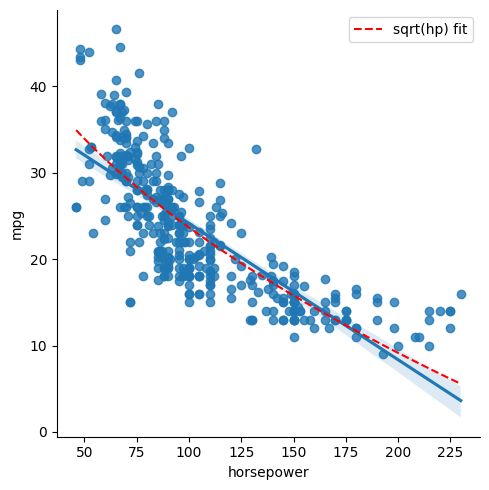

In [24]:
predicted_mpg_hp_sqrt = model.predict(vehicle_data[['sqrt(hp)']])

# do not modify below this line
r2_hp_sqrt = np.var(predicted_mpg_hp_sqrt) / np.var(vehicle_data['mpg'])
print('Multiple R^2 using sqrt(hp): ', r2_hp_sqrt)

sns.lmplot(x='horsepower', y='mpg', data=vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_sqrt,
         color = 'r', linestyle='--', label='sqrt(hp) fit');
plt.legend();

The visualization shows a slight improvement, but note that the underlying pattern is parabolic--suggesting that perhaps we should try a quadratic feature. Next, we use the power of multiple linear regression to **add an additional feature.**

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Add an Additional Feature

For the second part of this lab, we move from SLR to multiple linear regression.

Until now, we have established relationships between one independent explanatory variable and one response variable. However, with real-world problems you will often want to use **multiple features** to model and predict a response variable. Multiple linear regression attempts to model the relationship between two or more explanatory variables and a response variable by fitting a linear equation to the observed data.

We can consider including functions of existing features as **new features** to help improve the predictive power of our model. (This is something we will discuss in further detail in the Feature Engineering lecture.)

The cell below adds a column which contains the square of the horsepower for each car in the dataset.

In [25]:
# just run this cell
vehicle_data['hp^2'] = vehicle_data['horsepower'] ** 2
vehicle_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,sqrt(hp),hp^2
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle,6.782330,2116.0
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan,6.782330,2116.0
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel),6.928203,2304.0
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel),6.928203,2304.0
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel,6.928203,2304.0


---
## Question 3

### Question 3a

Using scikit learn's `LinearRegression`, create and fit a model that tries to predict `mpg` from `horsepower` AND `hp^2` using the DataFrame `vehicle_data`. Name your model `model_multi`.

**Hint**: We did something very similar in Question 2.

<!--
BEGIN QUESTION
name: q3a
-->

In [26]:
model_multi = LinearRegression() # by default, fit_intercept=True
model_multi.fit(X = vehicle_data[['horsepower', 'hp^2']], y= vehicle_data['mpg'])

LinearRegression()

In [ ]:
grader.check("q3a")

After fitting, we can see the coefficients and intercept. Note, there are now two elements in `model_multi.coef_`, since there are two features.

In [28]:
model_multi.intercept_

np.float64(56.90009970211301)

In [29]:
model_multi.coef_

array([-0.46618963,  0.00123054])

---

### Question 3b

Using the above values, in LaTeX, write out the function that the model is using to predict `mpg` from `horsepower` and `hp^2`.

<!--
BEGIN QUESTION
name: q3b
-->

$$
mpg_{predicted} = 56.90 - 0.47 \times horsepower + 0.001 \times hp^2
$$

<br/><br/>

The plot below shows the prediction of our model. It's much better!

Multiple R^2 using both horsepower and horsepower squared:  0.6875590305127548


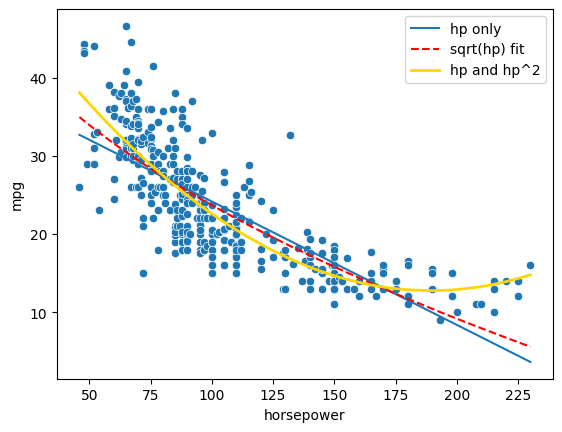

In [30]:
# just run this cell
predicted_mpg_multi = model_multi.predict(vehicle_data[['horsepower', 'hp^2']])
r2_multi = np.var(predicted_mpg_multi) / np.var(vehicle_data['mpg'])
print('Multiple R^2 using both horsepower and horsepower squared: ', r2_multi)

sns.scatterplot(x='horsepower', y='mpg', data=vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_only, label='hp only');
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_sqrt, color = 'r', linestyle='--', label='sqrt(hp) fit');
plt.plot(vehicle_data['horsepower'],  predicted_mpg_multi, color = 'gold', linewidth=2, label='hp and hp^2');
plt.legend();

---

### Question 3c

In the cell below, we assign the mean of the `mpg` column of the vehicle `data` dataframe to `mean_mpg`. Given this information, what is the mean of the `mean_predicted_mpg_hp_only`, `predicted_mpg_hp_sqrt`, and `predicted_mpg_multi` arrays?

Hint: You should not have to call `np.mean` in your code.

<!--
BEGIN QUESTION
name: q3c
-->

In [36]:
mean_mpg = np.mean(vehicle_data['mpg'])
mean_predicted_mpg_hp_only = mean_mpg # 最小二乘性质决定的 y_bar = a + b * x_bar
mean_predicted_mpg_hp_sqrt = mean_mpg 
mean_predicted_mpg_multi = mean_mpg

In [39]:
# print(np.mean(predicted_mpg_hp_sqrt))
# print(mean_mpg)

# print(np.mean(predicted_mpg_multi))


23.445918367346934
23.445918367346938
23.445918367346938


In [ ]:
grader.check("q3c")

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Faulty Feature Engineering: Redundant Features

Suppose we used the following linear model:

\begin{align}
\text{mpg} &= \theta_0 + \theta_1 \cdot \text{horsepower} + \\
&\theta_2 \cdot \text{horsepower}^2 + \theta_3 \cdot \text{horsepower}
\end{align}

Notice that `horsepower` appears twice in our model!! We will explore how this redundant feature affects our modeling.

---

## Question 4

### Question 4a: Linear Algebra

Construct a matrix `X_redundant` that uses the vehicle `data` DataFrame to encode the "three" features above, as well as a bias feature.

**Hint**: Use the `add_intercept` term you implemented in Question 1a.

<!--
BEGIN QUESTION
name: q4a
-->

In [40]:
X_redundant = add_intercept(vehicle_data[['horsepower', 'hp^2', 'horsepower']])
X_redundant.shape

(392, 4)

In [41]:
grader.check("q4a")

q4a results: All test cases passed!

<br/><br/>
Now, run the cell below to find the analytical OLS Estimate using the `get_analytical_sol` function you wrote in Question 1c.

Depending on the machine that you run your code on, you should either see a singular matrix error or end up with thetas that are nonsensical (magnitudes greater than 10^15). This is not good!

In [44]:
# just run this cell
# the try-except block suppresses errors during submission
import traceback
try:
    analytical_thetas = get_analytical_sol(X_redundant, vehicle_data['mpg'])
    analytical_thetas
except Exception as e:
    print(traceback.format_exc())

---

### Question 4b

In the cell below, explain why we got the error above when trying to calculate the analytical solution to predict `mpg`.

<!--
BEGIN QUESTION
name: q4b
-->

_解析方法不一定正确，比较理想但不现实（但是上面并没有error诶）_

<br/>
Note: While we encountered errors when using the linear algebra approach, a model fitted with `sklearn` will not encounter matrix singularity errors since it uses numerical methods to find optimums (to be covered in Gradient Descent lecture).

In [43]:
# just run this cell
# sklearn finds optimal parameters despite redundant features
model_redundant = LinearRegression(fit_intercept=False) # X_redundant already has an intercept column
model_redundant.fit(X = X_redundant, y = vehicle_data['mpg'])
model_redundant.coef_

array([ 5.69000997e+01, -2.33094815e-01,  1.23053610e-03, -2.33094815e-01])

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Overfitting with Too Many Features

Let's take what we've learned so far and go one step further: introduce even more features.

Again, using scikit learn's `LinearRegression`, we fit a model that tries to predict `mpg` using each of the following as features:
- `horsepower`
- `hp^2`
- `model_year`
- `acceleration`

In [45]:
# just run this cell
desired_columns = ['horsepower', 'hp^2', 'model_year', 'acceleration']
model_overfit = LinearRegression()
model_overfit.fit(X = vehicle_data[desired_columns], y= vehicle_data['mpg'])
predicted_mpg_overfit = model_overfit.predict(vehicle_data[['horsepower', 'hp^2', 'model_year', 'acceleration']])

<br/>
The plot below shows the prediction of our more sophisticated model. Note we arbitrarily plot against horsepower for the ease of keeping our plots 2-dimensional.

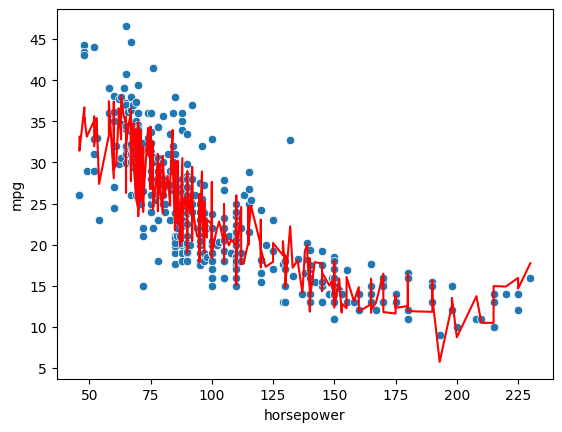

In [46]:
# just run this cell
sns.scatterplot(x='horsepower', y='mpg', data=vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg_overfit, color = 'r');

Think about what you see in the above plot. Why is the shape of our prediction curve so jagged? Do you think this is a good model to predict the `mpg` of some car we don't already have information on?

This idea –the **bias-variance tradeoff**– is an idea we will explore in the coming weeks.

---

## Question 5: Comparing $R^2$

Lastly, set `r2_overfit` to be the multiple $R^2$ coefficient obtained by using `model_overfit`.

- Hint: This is very similar to several pre-computed cells in Questions 1c, 2b, and 3b.

<!--
BEGIN QUESTION
name: q5
-->

In [48]:
r2_overfit = np.var(predicted_mpg_overfit) / np.var(vehicle_data['mpg'])
r2_overfit

np.float64(0.8163086433998654)

In [ ]:
grader.check("q5")

Comparing this model with previous models:

In [50]:
# just run this cell
# compares q1, q2, q3, and overfit models (ignores redundant model)
print('Multiple R^2 using only horsepower: ', r2_hp_only)
print('Multiple R^2 using sqrt(hp): ', r2_hp_sqrt)
print('Multiple R^2 using both hp and hp^2: ', r2_multi)
print('Multiple R^2 using hp, hp^2, model year, and acceleration: ', r2_overfit)

Multiple R^2 using only horsepower:  0.6059482578894348
Multiple R^2 using sqrt(hp):  0.6437035832706468
Multiple R^2 using both hp and hp^2:  0.6875590305127548
Multiple R^2 using hp, hp^2, model year, and acceleration:  0.8163086433998654


If everything was done correctly, the multiple $R^2$ of our latest model should be substantially higher than that of the previous models. This is because multiple $R^2$ increases with the number of covariates (i.e., features) we add to our model. 

<br/>

**A Word on Overfitting**: We might not always want to use models with large multiple $R^2$ values because these models could be **overfitting** to our specific sample data, and won't generalize well to unseen data from the population. Again, this is an idea we will explore in future lectures and assignments.

# Congratulations! You finished the lab!

---

